In [1]:
import torch
from torch import nn
import numpy as np
import csv
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection as model_selection
from tqdm import tqdm

In [2]:
with open("C:/Users/User/Documents/Machine Learning/social listening project/tf_idf.csv", encoding="utf-8") as f:
    # đọc file vector, đưa về dạng array[float]
    reader = csv.reader(f)
    data_list = [row for row in reader]
    data_list = np.asarray(data_list,dtype=np.float64)

In [3]:
with open("C:/Users/User/Documents/Machine Learning/social listening project/Data dùng được.csv", encoding="utf-8") as f:
    reader = csv.reader(f)
    label_list = [row for row in reader]
    label_list = label_list
    # 0 = Ukraina and 1 = Nga
    for i in range(0,len(label_list)):
        if label_list[i][1]=="U":
            label_list[i]=0
        else: 
            label_list[i]=1

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_list, label_list, train_size=85/100,test_size=15/100, random_state=0)
# print ("X_train: ", len(X_train))
# print ("y_train: ", len(y_train))
# print("X_test: ", len(X_test))
# print ("y_test: ", len(y_test))

In [86]:
class NLP(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim): # input_dim = 6329 output_dim = 1
        super(NLP, self).__init__()
        # z = w1x1 + w2x2 + ... + wnxn + b = hàm nn.linear
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, output_dim*500),
            nn.Sigmoid(),
            nn.Linear(output_dim*500, output_dim*100),
            nn.Sigmoid(),
            nn.Linear(output_dim*100,output_dim*20),
            nn.Sigmoid(),
            nn.Linear(output_dim*20,output_dim)
        )
    def forward(self, x):
        # x = [5000 x 6329]
        # self.linear(x) = [5000 x 1] 
        # output = y_predict = sigmoid(self.linear(x)) = [5000 x 1]
        outputs = torch.sigmoid(self.linear_relu_stack(x))
        return outputs

In [3]:
m = nn.Dropout(p=0.2)
input = torch.randn(4, 5)
print(input)
output = m(input)
print(output)

tensor([[ 0.2913,  0.7440,  0.1501, -1.4122, -0.8911],
        [ 0.7348, -0.6032, -0.4588,  0.5571, -0.8974],
        [-0.3789, -0.2151,  0.7571, -0.6171,  0.7475],
        [-0.8846,  2.0272,  1.3109, -0.1417,  0.9968]])
tensor([[ 0.3642,  0.9300,  0.0000, -1.7653, -1.1139],
        [ 0.0000, -0.7540, -0.0000,  0.6964, -1.1217],
        [-0.4736, -0.2689,  0.9463, -0.0000,  0.9344],
        [-1.1057,  2.5340,  1.6387, -0.0000,  1.2459]])


In [ ]:
"""
optimizer Adam
Đảo data lên
Chia mini-batch
Thử dropout
Tăng lên 20 layer
giảm epoch xuống 100

"""

In [87]:
epochs = 5000
input_dim = len(X_train[0])
output_dim = 1 # đầu ra là số trong khoảng 0
learning_rate = 0.01

In [88]:
model = NLP(input_dim,output_dim)
loss_function = torch.nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.GD(model.parameters(), lr=learning_rate)

In [5]:
X_train, X_test = torch.tensor(X_train,dtype=torch.float32),torch.tensor(X_test,dtype=torch.float32)
y_train, y_test = torch.tensor(y_train,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32)

In [6]:
print(X_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [90]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm((range(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad()   # đặt gradient về 0
    outputs = model(X_train)    # train 
    # torch.squeeze() đưa [5000 x 1] về [5000]
    loss = loss_function(torch.squeeze(outputs), labels) # tính loss
    loss.backward() # tính gradient của w
    optimizer.step() # cập nhật w
    
    iter+=1
    if iter%100==0:   # kiểm tra mỗi 10000 epoch
        with torch.no_grad():   # không tính gradient
            # tính loss và độ chính xác cho test_set
            outputs_test = torch.squeeze(model(X_test)) # dãy xác suất dự đoán vd(0.51 0.76 0.01)
            loss_test = loss_function(outputs_test, y_test)
            
            predicted = outputs_test.round().detach().numpy()  # làm tròn và chuyển thành array
            total_test = y_test.size(0) # số test sample
            correct_test = np.sum(predicted == y_test.detach().numpy()) # số sample dự đoán đúng
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # tính loss và độ chính xác cho training_set           
            total = y_train.size(0)
            correct = np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}")

Training Epochs:   2%|▏         | 100/5000 [01:19<56:55,  1.43it/s] 

Iteration: 100. 
Test - Loss: 0.6066007614135742. Accuracy: 71.01616628175519
Train -  Loss: 0.6053863763809204. Accuracy: 71.21304791029561


Training Epochs:   4%|▍         | 200/5000 [02:29<51:12,  1.56it/s]  

Iteration: 200. 
Test - Loss: 0.6022196412086487. Accuracy: 71.01616628175519
Train -  Loss: 0.6005480289459229. Accuracy: 71.21304791029561


Training Epochs:   6%|▌         | 300/5000 [03:30<48:55,  1.60it/s]

Iteration: 300. 
Test - Loss: 0.6020126938819885. Accuracy: 71.01616628175519
Train -  Loss: 0.6002529263496399. Accuracy: 71.21304791029561


Training Epochs:   8%|▊         | 400/5000 [04:31<47:17,  1.62it/s]

Iteration: 400. 
Test - Loss: 0.6020147800445557. Accuracy: 71.01616628175519
Train -  Loss: 0.6002342104911804. Accuracy: 71.21304791029561


Training Epochs:  10%|█         | 500/5000 [05:33<47:28,  1.58it/s]

Iteration: 500. 
Test - Loss: 0.6020186543464661. Accuracy: 71.01616628175519
Train -  Loss: 0.6002327799797058. Accuracy: 71.21304791029561


Training Epochs:  12%|█▏        | 600/5000 [06:36<48:10,  1.52it/s]

Iteration: 600. 
Test - Loss: 0.6020198464393616. Accuracy: 71.01616628175519
Train -  Loss: 0.6002326011657715. Accuracy: 71.21304791029561


Training Epochs:  14%|█▍        | 700/5000 [07:36<45:09,  1.59it/s]

Iteration: 700. 
Test - Loss: 0.6020201444625854. Accuracy: 71.01616628175519
Train -  Loss: 0.6002325415611267. Accuracy: 71.21304791029561


Training Epochs:  16%|█▌        | 800/5000 [08:38<43:26,  1.61it/s]

Iteration: 800. 
Test - Loss: 0.6020200252532959. Accuracy: 71.01616628175519
Train -  Loss: 0.6002324223518372. Accuracy: 71.21304791029561


Training Epochs:  18%|█▊        | 900/5000 [09:39<42:06,  1.62it/s]

Iteration: 900. 
Test - Loss: 0.6020201444625854. Accuracy: 71.01616628175519
Train -  Loss: 0.6002323031425476. Accuracy: 71.21304791029561


Training Epochs:  20%|██        | 1000/5000 [10:39<40:01,  1.67it/s]

Iteration: 1000. 
Test - Loss: 0.6020200252532959. Accuracy: 71.01616628175519
Train -  Loss: 0.6002322435379028. Accuracy: 71.21304791029561


Training Epochs:  22%|██▏       | 1100/5000 [11:38<39:56,  1.63it/s]

Iteration: 1100. 
Test - Loss: 0.6020200252532959. Accuracy: 71.01616628175519
Train -  Loss: 0.6002321243286133. Accuracy: 71.21304791029561


Training Epochs:  24%|██▍       | 1200/5000 [12:36<35:26,  1.79it/s]

Iteration: 1200. 
Test - Loss: 0.6020199656486511. Accuracy: 71.01616628175519
Train -  Loss: 0.6002320051193237. Accuracy: 71.21304791029561


Training Epochs:  26%|██▌       | 1300/5000 [13:29<34:23,  1.79it/s]

Iteration: 1300. 
Test - Loss: 0.6020199656486511. Accuracy: 71.01616628175519
Train -  Loss: 0.600231945514679. Accuracy: 71.21304791029561


Training Epochs:  28%|██▊       | 1400/5000 [14:23<33:30,  1.79it/s]

Iteration: 1400. 
Test - Loss: 0.6020198464393616. Accuracy: 71.01616628175519
Train -  Loss: 0.6002317667007446. Accuracy: 71.21304791029561


Training Epochs:  30%|███       | 1500/5000 [15:16<31:00,  1.88it/s]

Iteration: 1500. 
Test - Loss: 0.6020198464393616. Accuracy: 71.01616628175519
Train -  Loss: 0.6002317070960999. Accuracy: 71.21304791029561


Training Epochs:  32%|███▏      | 1600/5000 [16:08<28:29,  1.99it/s]

Iteration: 1600. 
Test - Loss: 0.6020197868347168. Accuracy: 71.01616628175519
Train -  Loss: 0.6002315878868103. Accuracy: 71.21304791029561


Training Epochs:  34%|███▍      | 1700/5000 [17:00<31:15,  1.76it/s]

Iteration: 1700. 
Test - Loss: 0.6020197868347168. Accuracy: 71.01616628175519
Train -  Loss: 0.6002314686775208. Accuracy: 71.21304791029561


Training Epochs:  36%|███▌      | 1800/5000 [17:57<29:29,  1.81it/s]

Iteration: 1800. 
Test - Loss: 0.6020196080207825. Accuracy: 71.01616628175519
Train -  Loss: 0.6002313494682312. Accuracy: 71.21304791029561


Training Epochs:  38%|███▊      | 1900/5000 [18:52<29:33,  1.75it/s]

Iteration: 1900. 
Test - Loss: 0.6020196080207825. Accuracy: 71.01616628175519
Train -  Loss: 0.6002312302589417. Accuracy: 71.21304791029561


Training Epochs:  40%|████      | 2000/5000 [19:43<26:11,  1.91it/s]

Iteration: 2000. 
Test - Loss: 0.6020195484161377. Accuracy: 71.01616628175519
Train -  Loss: 0.6002311706542969. Accuracy: 71.21304791029561


Training Epochs:  42%|████▏     | 2100/5000 [20:38<27:46,  1.74it/s]

Iteration: 2100. 
Test - Loss: 0.6020195484161377. Accuracy: 71.01616628175519
Train -  Loss: 0.6002310514450073. Accuracy: 71.21304791029561


Training Epochs:  44%|████▍     | 2200/5000 [21:33<27:25,  1.70it/s]

Iteration: 2200. 
Test - Loss: 0.6020194888114929. Accuracy: 71.01616628175519
Train -  Loss: 0.600230872631073. Accuracy: 71.21304791029561


Training Epochs:  46%|████▌     | 2300/5000 [22:27<23:48,  1.89it/s]

Iteration: 2300. 
Test - Loss: 0.6020194292068481. Accuracy: 71.01616628175519
Train -  Loss: 0.600230872631073. Accuracy: 71.21304791029561


Training Epochs:  48%|████▊     | 2400/5000 [23:20<23:28,  1.85it/s]

Iteration: 2400. 
Test - Loss: 0.6020194292068481. Accuracy: 71.01616628175519
Train -  Loss: 0.6002307534217834. Accuracy: 71.21304791029561


Training Epochs:  50%|█████     | 2500/5000 [24:12<22:54,  1.82it/s]

Iteration: 2500. 
Test - Loss: 0.6020193696022034. Accuracy: 71.01616628175519
Train -  Loss: 0.6002306342124939. Accuracy: 71.21304791029561


Training Epochs:  52%|█████▏    | 2600/5000 [25:05<21:26,  1.87it/s]

Iteration: 2600. 
Test - Loss: 0.6020192503929138. Accuracy: 71.01616628175519
Train -  Loss: 0.6002305150032043. Accuracy: 71.21304791029561


Training Epochs:  54%|█████▍    | 2700/5000 [25:59<21:00,  1.82it/s]

Iteration: 2700. 
Test - Loss: 0.6020192503929138. Accuracy: 71.01616628175519
Train -  Loss: 0.6002303957939148. Accuracy: 71.21304791029561


Training Epochs:  56%|█████▌    | 2800/5000 [26:53<21:17,  1.72it/s]

Iteration: 2800. 
Test - Loss: 0.602019190788269. Accuracy: 71.01616628175519
Train -  Loss: 0.6002302765846252. Accuracy: 71.21304791029561


Training Epochs:  58%|█████▊    | 2900/5000 [27:49<18:56,  1.85it/s]

Iteration: 2900. 
Test - Loss: 0.6020191311836243. Accuracy: 71.01616628175519
Train -  Loss: 0.6002302169799805. Accuracy: 71.21304791029561


Training Epochs:  60%|██████    | 3000/5000 [28:43<17:39,  1.89it/s]

Iteration: 3000. 
Test - Loss: 0.6020191311836243. Accuracy: 71.01616628175519
Train -  Loss: 0.6002300977706909. Accuracy: 71.21304791029561


Training Epochs:  62%|██████▏   | 3100/5000 [29:36<17:54,  1.77it/s]

Iteration: 3100. 
Test - Loss: 0.6020191311836243. Accuracy: 71.01616628175519
Train -  Loss: 0.6002299785614014. Accuracy: 71.21304791029561


Training Epochs:  64%|██████▍   | 3200/5000 [30:30<17:03,  1.76it/s]

Iteration: 3200. 
Test - Loss: 0.6020190119743347. Accuracy: 71.01616628175519
Train -  Loss: 0.6002298593521118. Accuracy: 71.21304791029561


Training Epochs:  66%|██████▌   | 3300/5000 [31:22<15:24,  1.84it/s]

Iteration: 3300. 
Test - Loss: 0.6020190119743347. Accuracy: 71.01616628175519
Train -  Loss: 0.6002296805381775. Accuracy: 71.21304791029561


Training Epochs:  68%|██████▊   | 3400/5000 [32:15<15:02,  1.77it/s]

Iteration: 3400. 
Test - Loss: 0.6020189523696899. Accuracy: 71.01616628175519
Train -  Loss: 0.6002296805381775. Accuracy: 71.21304791029561


Training Epochs:  70%|███████   | 3500/5000 [39:38<14:36,  1.71it/s]    

Iteration: 3500. 
Test - Loss: 0.6020189523696899. Accuracy: 71.01616628175519
Train -  Loss: 0.6002295613288879. Accuracy: 71.21304791029561


Training Epochs:  72%|███████▏  | 3600/5000 [40:35<13:46,  1.69it/s]

Iteration: 3600. 
Test - Loss: 0.6020188331604004. Accuracy: 71.01616628175519
Train -  Loss: 0.6002293825149536. Accuracy: 71.21304791029561


Training Epochs:  74%|███████▍  | 3700/5000 [41:34<12:35,  1.72it/s]

Iteration: 3700. 
Test - Loss: 0.6020187735557556. Accuracy: 71.01616628175519
Train -  Loss: 0.6002293229103088. Accuracy: 71.21304791029561


Training Epochs:  76%|███████▌  | 3800/5000 [42:30<11:36,  1.72it/s]

Iteration: 3800. 
Test - Loss: 0.6020187139511108. Accuracy: 71.01616628175519
Train -  Loss: 0.6002292633056641. Accuracy: 71.21304791029561


Training Epochs:  78%|███████▊  | 3900/5000 [43:30<15:29,  1.18it/s]

Iteration: 3900. 
Test - Loss: 0.6020187139511108. Accuracy: 71.01616628175519
Train -  Loss: 0.6002290844917297. Accuracy: 71.21304791029561


Training Epochs:  80%|████████  | 4000/5000 [44:30<10:02,  1.66it/s]

Iteration: 4000. 
Test - Loss: 0.6020186543464661. Accuracy: 71.01616628175519
Train -  Loss: 0.600229024887085. Accuracy: 71.21304791029561


Training Epochs:  82%|████████▏ | 4100/5000 [45:28<09:20,  1.60it/s]

Iteration: 4100. 
Test - Loss: 0.6020186543464661. Accuracy: 71.01616628175519
Train -  Loss: 0.6002289056777954. Accuracy: 71.21304791029561


Training Epochs:  84%|████████▍ | 4200/5000 [46:30<08:32,  1.56it/s]

Iteration: 4200. 
Test - Loss: 0.6020184755325317. Accuracy: 71.01616628175519
Train -  Loss: 0.6002287864685059. Accuracy: 71.21304791029561


Training Epochs:  86%|████████▌ | 4300/5000 [47:32<08:07,  1.43it/s]

Iteration: 4300. 
Test - Loss: 0.6020184755325317. Accuracy: 71.01616628175519
Train -  Loss: 0.6002287268638611. Accuracy: 71.21304791029561


Training Epochs:  88%|████████▊ | 4400/5000 [48:32<06:32,  1.53it/s]

Iteration: 4400. 
Test - Loss: 0.6020184755325317. Accuracy: 71.01616628175519
Train -  Loss: 0.6002285480499268. Accuracy: 71.21304791029561


Training Epochs:  90%|█████████ | 4500/5000 [49:38<05:10,  1.61it/s]

Iteration: 4500. 
Test - Loss: 0.602018415927887. Accuracy: 71.01616628175519
Train -  Loss: 0.600228488445282. Accuracy: 71.21304791029561


Training Epochs:  92%|█████████▏| 4600/5000 [50:40<04:18,  1.55it/s]

Iteration: 4600. 
Test - Loss: 0.6020183563232422. Accuracy: 71.01616628175519
Train -  Loss: 0.6002283692359924. Accuracy: 71.21304791029561


Training Epochs:  94%|█████████▍| 4700/5000 [51:43<03:10,  1.58it/s]

Iteration: 4700. 
Test - Loss: 0.6020183563232422. Accuracy: 71.01616628175519
Train -  Loss: 0.6002283096313477. Accuracy: 71.21304791029561


Training Epochs:  96%|█████████▌| 4800/5000 [52:48<02:24,  1.39it/s]

Iteration: 4800. 
Test - Loss: 0.6020182371139526. Accuracy: 71.01616628175519
Train -  Loss: 0.6002281904220581. Accuracy: 71.21304791029561


Training Epochs:  98%|█████████▊| 4900/5000 [53:50<01:04,  1.56it/s]

Iteration: 4900. 
Test - Loss: 0.6020182371139526. Accuracy: 71.01616628175519
Train -  Loss: 0.6002280116081238. Accuracy: 71.21304791029561


Training Epochs: 100%|██████████| 5000/5000 [54:53<00:00,  1.52it/s]

Iteration: 5000. 
Test - Loss: 0.6020181775093079. Accuracy: 71.01616628175519
Train -  Loss: 0.6002278923988342. Accuracy: 71.21304791029561


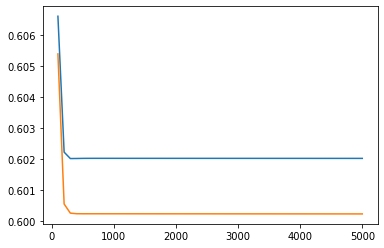

In [91]:
plt.plot(Iterations,losses_test)
plt.plot(Iterations,losses)